In [142]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from functools import reduce
import xgboost as xgb

In [301]:
COUNTRIES_FILE_PATH = "data/countries.csv"
SESSIONS_FILE_PATH = "data/sessions.csv"
TRAIN_USERS_PATH = "data/train_users_2.csv"
AGE_BUCKET_PATH = "data/age_gender_bkts.csv"
SESSION_PATH = "data/sessions.csv"
TEST_USERS_PATH = "data/test_users.csv"

### Loading the data

In [345]:
train_users = pd.read_csv(TRAIN_USERS_PATH)
test_users = pd.read_csv(TEST_USERS_PATH)
countries = pd.read_csv(COUNTRIES_FILE_PATH)
age_buckets = pd.read_csv(AGE_BUCKET_PATH)
sessions = pd.read_csv(SESSION_PATH)

unique_session_ids = sessions['user_id'].unique()

# Group session data
sessions = sessions.groupby('user_id')

unique_actions = sessions['action_detail'].nunique()
total_elapsed = sessions['secs_elapsed'].sum()
# convert to series for faster indexing
total_elapsed = pd.Series(data=total_elapsed.values.flatten(), index=total_elapsed.index)

# Drop columns we don't need
train_users = train_users.drop(['date_account_created', 'timestamp_first_active', 'date_first_booking',
                 'signup_flow', 'signup_method', 'affiliate_channel',
                 'first_affiliate_tracked'], axis=1)

# Do the same for our test
test_users = test_users.drop(['date_account_created', 'timestamp_first_active', 'date_first_booking',
                 'signup_flow', 'signup_method', 'affiliate_channel',
                 'first_affiliate_tracked'], axis=1)

features = train_users.columns[0:-1]

# Let's see what our columns are

print(features)
print(countries.columns)
print(age_buckets.columns)

Index(['id', 'gender', 'age', 'language', 'affiliate_provider', 'signup_app',
       'first_device_type', 'first_browser'],
      dtype='object')
Index(['country_destination', 'lat_destination', 'lng_destination',
       'distance_km', 'destination_km2', 'destination_language ',
       'language_levenshtein_distance'],
      dtype='object')
Index(['age_bucket', 'country_destination', 'gender',
       'population_in_thousands', 'year'],
      dtype='object')


### Filtering data we aren't going to use

In [346]:
# only get the users where we have their session information
user_ids = train_users['id']
train_users = train_users[user_ids.isin(unique_session_ids)]

### Loading Session Data For Users

In [311]:
def get_session_params(users):
    user_matrix = users.as_matrix()
    user_id_index = users.columns.get_loc('id')
    
    session_params = np.zeros((users.shape[0], 2))
    user_ids = []
    
    for i, user in enumerate(user_matrix):
        user_ids.append(user[user_id_index])
        actions = unique_actions.get(user[user_id_index])
        total = total_elapsed.get(user[user_id_index])
        session_params[i] = [actions, total]
    
    return pd.DataFrame(session_params, index=user_ids, columns=['unique_action_count', 'total_secs_elapsed'])

### Loading target country statistics and age bucket data

In [324]:
def get_country_params(users):
    destinations = countries['country_destination']
    country_params = []
    user_id_index = users.columns.get_loc('id')
    country_index = users.columns.get_loc('country_destination')
    user_ids = []
    
    for user in users.as_matrix():
        country = user[country_index]
        user_id = user[user_id_index]
        user_ids.append(user_id)
        params = countries[country == destinations]
        cols = params.columns
        vals = params.values
        if len(vals) is 0:
            vals = np.zeros((1, len(cols)), dtype=object)
            
        zipped = zip(cols.tolist(), vals[0].tolist())
        country_params.append(dict(zipped))
    
    country_params = pd.DataFrame(data=country_params, index=user_ids)
        
    return country_params

get_country_params(train_users[0:5])

,country_destination,destination_km2,destination_language,distance_km,language_levenshtein_distance,lat_destination,lng_destination
d1mm9tcy42,0,0.0,0,0.0,0.0,0.000000,0.00000
xwxei6hdk4,US,9826675.0,eng,0.0,0.0,36.966427,-95.84403
ro2stddszp,0,0.0,0,0.0,0.0,0.000000,0.00000
qtw88d9pbl,0,0.0,0,0.0,0.0,0.000000,0.00000
awiurksqr3,US,9826675.0,eng,0.0,0.0,36.966427,-95.84403


In [313]:
def get_age_bucket_params(users):
    bucket_params = np.zeros((users.shape[0], 1))

    age_index = users.columns.get_loc('age')
    gender_index = users.columns.get_loc('gender')
    user_id_index = users.columns.get_loc('id')
    user_ids = []

    def _str_age_to_tuple(age_str):
        age_range = str.split(age_str.strip("+"), "-")
        if len(age_range) == 1:
            return (int(age_range[0]),)
        return (int(age_range[0]), int(age_range[1]))
    
    def _in_age_range(age_range, age):
        if len(age_range) is 1:
            return age >= age_range[0]
        
        return age > age_range[0] and age < age_range[1]
    
    def _index_for_age(age):
        return list(map(lambda age_range: _in_age_range(age_range, age), bucket))
    
    def _try_convert(num):
        try:
            return int(num)
        except ValueError:
            return 0
        
    bucket_matrix = age_buckets.as_matrix()
    
    for i,user in enumerate(users.as_matrix()):
        user_ids.append(user[user_id_index])
        user_destination = user[-1]
        user_gender = user[gender_index].lower()
        user_age = _try_convert(user[age_index])
        
        params_for_country = list(filter(lambda row: row[1] == user_destination, bucket_matrix))

        bucket_for_gender = list(filter(lambda row: _in_age_range(_str_age_to_tuple(row[0]), user_age), params_for_country))

        param = list(filter(lambda row: row[2] == user_gender, bucket_for_gender))
        
        if len(param) is 0:
            continue
        
        bucket_params[i] = param[0][-2]
        
    return pd.DataFrame(bucket_params, index=user_ids, columns=[age_buckets.columns[-2]])

### Getting insights on the data

In [314]:
for feature in features:
    print("Description for: " + feature)
    print(train_users[feature].describe())
    print("\n\n")

Description for: id
count          73815
unique         73815
top       roipr4mghn
freq               1
Name: id, dtype: object



Description for: gender
count         73815
unique            4
top       -unknown-
freq          37788
Name: gender, dtype: object



Description for: age
count    41567.000000
mean        42.414993
std        111.201954
min          1.000000
25%         27.000000
50%         32.000000
75%         41.000000
max       2014.000000
Name: age, dtype: float64



Description for: language
count     73815
unique       24
top          en
freq      71100
Name: language, dtype: object



Description for: affiliate_provider
count      73815
unique        17
top       direct
freq       46814
Name: affiliate_provider, dtype: object



Description for: signup_app
count     73815
unique        4
top         Web
freq      57016
Name: signup_app, dtype: object



Description for: first_device_type
count           73815
unique              9
top       Mac Desktop
freq      

### Visualizing the data

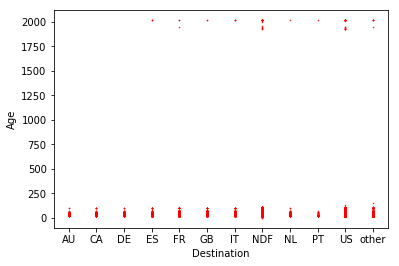

In [315]:
def plot_user_range(users):
    plt.plot(users['country_destination'], users['age'], 'ro', markersize=.5)
    plt.ylabel('Age')
    plt.xlabel('Destination')
    
plot_user_range(train_users)

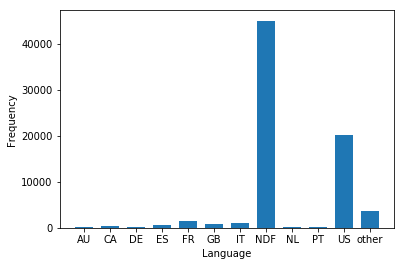

In [316]:
def plot_destination_dist(users):
    value_counts = train_users['country_destination'].value_counts()
    width = 0.7
    indicies = value_counts.axes[0]
    country_counts = value_counts.values

#     ax.set_yscale('log')
    plt.bar(indicies, country_counts, width)
#     plt.yscale('log')
    plt.ylabel('Frequency')
    plt.xlabel('Language')

plot_destination_dist(train_users)

### Insights


The data clearly shows there's some skewed data in the age column that may effect our results.

Text(0.5,0,'Language')

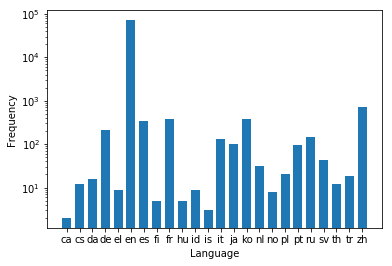

In [317]:
value_counts = train_users['language'].value_counts()
width = 0.7
indicies = value_counts.axes[0]
country_counts = value_counts.values

# plt.set_yscale('log')
plt.bar(indicies, country_counts, width)
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Language')

### Cleaning Age

In [318]:
train_users = train_users[(train_users['age'] > 16) & (train_users['age'] <= 95)]

### Plot After:

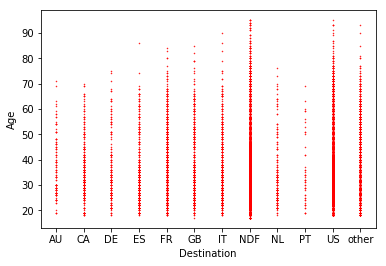

In [319]:
plot_user_range(train_users)

### Putting the data together

In [347]:
train_bucket_params = get_age_bucket_params(train_users)
test_bucket_params = get_age_bucket_params(test_users)

In [348]:
# train_country_params = get_country_params(train_users)
# train_country_params = train_country_params.drop('country_destination', axis=1)

# test_country_params = get_country_params(test_users)

In [349]:
train_session_params = get_session_params(train_users)
test_session_params = get_session_params(test_users)

In [350]:
# params = train_users.append(country_params).append(bucket_params)
# .append(session_params)
train_users.set_index('id', inplace=True)
test_users.set_index('id', inplace=True)

In [351]:
# merge all of our params using an inner join on the index
train_dfs = [train_users, train_bucket_params, train_session_params]
test_dfs = [test_users, test_bucket_params, test_session_params]

train_params = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), train_dfs)

test_params = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), test_dfs)

In [354]:
print(train_params.columns)
print(test_params.columns)


Index(['gender', 'age', 'language', 'affiliate_provider', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination',
       'population_in_thousands', 'unique_action_count', 'total_secs_elapsed'],
      dtype='object')
Index(['gender', 'age', 'language', 'affiliate_provider', 'signup_app',
       'first_device_type', 'first_browser', 'population_in_thousands',
       'unique_action_count', 'total_secs_elapsed'],
      dtype='object')


In [377]:
destinations = train_params['country_destination']

categorical = pd.Categorical(destinations)

categories = categorical.categories

category_codes = categorical.codes

y_train = category_codes
# y_test = category_codes[32647:]

category_count = len(categories)

combined_test_and_train = pd.get_dummies(pd.concat([train_params.drop('country_destination', axis=1), test_params]))

x_train_params = combined_test_and_train[:len(train_params)]
x_test_params = combined_test_and_train[len(test_params):]

# print(len(x_train_params.columns))
# print(len(x_test_params.columns))

# print(x_test_params)

# x_train_params = pd.get_dummies()

# x_test_params = pd.get_dummies(test_params)

103
103


In [378]:
xg_train = xgb.DMatrix(x_train_params, label=y_train)
xg_test = xgb.DMatrix(x_test_params)

In [379]:
# setup parameters for xgboost
param = {}

param['booster'] = 'gblinear'

param['silent'] = 1

param['nthread'] = 4

# learning rate
param['eta'] = 0.3

# depth 
param['max_depth'] = 2

# use softmax multi-class classification

param['objective'] = 'multi:softmax'

param['num_class'] = category_count

watchlist = [(xg_train, 'train')]

num_round = 10

bst = xgb.train(param, xg_train, num_round, watchlist)

[0]	train-merror:0.305995
[1]	train-merror:0.287272
[2]	train-merror:0.287326
[3]	train-merror:0.287286
[4]	train-merror:0.287259
[5]	train-merror:0.287326
[6]	train-merror:0.28734
[7]	train-merror:0.287286
[8]	train-merror:0.287367
[9]	train-merror:0.287381


In [387]:
train_pred = bst.predict(xg_train)
test_pred = bst.predict(xg_test, output_margin=True)

In [389]:
print("Train error: " + str(np.count_nonzero(train_pred == y_train) / len(y_train)))

Train error: 0.7126193863035968


In [390]:
def get_top_three(predictions):
    predictions = np.array(predictions, copy=True)
    """
    for each prediction record the index of the top three in an array
    """
    indexed_predictions = []
    
    for prob_vec in predictions:
        maximum = float("-inf")
        maximum_index = -1
        top_three = []
        
        while len(top_three) < 3:
            # go through each probability and record maximum number and the index of that number
            for i, prob in enumerate(prob_vec):
                if prob > maximum:
                    maximum = prob
                    maximum_index = i
            # add that maximum to our array, reset the index and set the index in
            # the array to a small value
            # NOTE: we don't remove it because that would mess up the indexing

            prob_vec[maximum_index] = float("-inf")
            top_three.append(maximum_index)
            maximum = float("-inf")
            
        indexed_predictions.append(top_three)
    
    labeled_predictions = []
    
    for top_three_preds in indexed_predictions:
        preds = []
        for index in top_three_preds:
            preds.append(categories[index])
        labeled_predictions.append(preds)
        

    
    return labeled_predictions

In [395]:
predictions = get_top_three(test_pred)

In [435]:
zipped_preds = list(zip(list(test_users.index), predictions))

csv = []

for id, preds in zipped_preds:
    for pred in preds:
        csv.append([id, pred])


In [446]:
# save
# np.array(csv, dtype=str)

csv_df = pd.DataFrame(np.array(csv), columns=["id","country"])
csv_df = csv_df.set_index('id')
csv_df.to_csv("submission.csv")
# np.savetxt("submission.csv", np.array(csv), delimiter=",", header="id,destination")

# np.array(csv)